In [1]:
pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
aiohappyeyeballs             2.4.0
aiohttp                      3.10.5
aiosignal                    1.3.1
airsim                       1.8.1
alembic                      1.13.2
annotated-types              0.7.0
anyio                        4.4.0Note: you may need to restart the kernel to use updated packages.

argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
audioread                    3.0.1
Babel                        2.15.0
backports.ssl_match_hostname 3.7.0.1
bayesian-optimization        1.5.1
beautifulsoup4               4.12.3
bleach                       6.1.0
blinker                      1.8.2
captum                       0.7.0
certifi                      2024.7.4
c


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
data_path = "C:/Users/admin/Desktop/Giggle_Function_2"

In [2]:
import os
import numpy as np
import librosa

def extract_spectrogram(audio_file, n_mels=128, n_fft=2048, hop_length=512):
    y, sr = librosa.load(audio_file, sr=None)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect

def load_data(data_path):
    X, y = [], []
    emotions = {
        "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
        "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
    }
    confident_emotions = ['03', '02']  # Happy, Calm -> Confident
    not_confident_emotions = ['04', '06']  # Sad, Fearful -> Not Confident
    
    # Loop over all actors' folders
    for actor_folder in os.listdir(data_path):
        actor_path = os.path.join(data_path, actor_folder)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    emotion_code = file.split("-")[2]
                    label = 1 if emotion_code in confident_emotions else 0  # 1 for confident, 0 for not confident
                    file_path = os.path.join(actor_path, file)
                    
                    # Extract spectrogram
                    spect = extract_spectrogram(file_path)
                    X.append(spect)
                    y.append(label)
    
    return np.array(X), np.array(y)

X, y = load_data(data_path)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1440, 128) + inhomogeneous part.

In [3]:
def extract_spectrogram(audio_file, n_mels=128, n_fft=2048, hop_length=512, fixed_width=128):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)
    
    # Convert audio to mel spectrogram
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    
    # Convert to decibel (dB) scale
    spect = librosa.power_to_db(spect, ref=np.max)
    
    # Pad or trim the spectrogram to a fixed width
    if spect.shape[1] < fixed_width:
        # Pad with zeros if spectrogram is shorter than fixed width
        pad_width = fixed_width - spect.shape[1]
        spect = np.pad(spect, ((0, 0), (0, pad_width)), mode='constant')
    else:
        # Trim if spectrogram is longer than fixed width
        spect = spect[:, :fixed_width]
    
    return spect


In [4]:
X, y = load_data(data_path)

In [5]:
# Normalize the data by dividing by the maximum value in the dataset
X = X / np.max(X)


In [6]:
# Reshape X to add the channel dimension (1 for grayscale images like spectrograms)
X = X[..., np.newaxis]  # Now X shape will be (num_samples, 128, 128, 1)


In [7]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (1440, 128, 128, 1)
Shape of y: (1440,)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [9]:
def transformer_lstm_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Convolutional Layers for Feature Extraction
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten the output for the Transformer
    x = layers.Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)  # Reshape to (timesteps, features)

    # Transformer Encoder
    transformer_layer = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, transformer_layer])  # Residual connection
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # LSTM Layer
    x = layers.LSTM(128)(x)
    
    # Dense Output Layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # Compile Model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (128, 128, 1)
model = transformer_lstm_model(input_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 126, 126, 32)      │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 63, 63, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 61, 61, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 30, 30, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 28, 28, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 14, 14, 128)       │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 196, 128)          │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 196, 128)          │         131,968 │ reshape[0][0],             │
│ (MultiHeadAttention)          │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 196, 128)          │               0 │ reshape[0][0],             │
│                               │                           │                 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 196, 128)          │             256 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 196, 64)           │           8,256 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 128)               │          98,816 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │             129 │ lstm[0][0]                 │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 332,097 (1.27 MB)

 Trainable params: 332,097 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 589ms/step - accuracy: 0.6840 - loss: 0.6146 - val_accuracy: 0.7706 - val_loss: 0.6018
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 540ms/step - accuracy: 0.7339 - loss: 0.6030 - val_accuracy: 0.7706 - val_loss: 0.5428
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 551ms/step - accuracy: 0.7069 - loss: 0.6075 - val_accuracy: 0.7706 - val_loss: 0.5387
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 555ms/step - accuracy: 0.7021 - loss: 0.6217 - val_accuracy: 0.7706 - val_loss: 0.5396
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 556ms/step - accuracy: 0.6869 - loss: 0.6371 - val_accuracy: 0.7706 - val_loss: 0.5404
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 545ms/step - accuracy: 0.7199 - loss: 0.5938 - val_accuracy: 0.7706 - val_loss: 0.5404
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 554ms/step - accuracy: 0.7276 - loss: 0.5899 - val_accuracy: 0.7706 - val_loss: 0.5465
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 553ms/step - accuracy: 0.7240 - loss: 0.5897 - val_accu

In [13]:
from tensorflow.keras.optimizers import Adam

# Adjust the learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 126, 126, 32)      │             320 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 63, 63, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 61, 61, 64)        │          18,496 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 30, 30, 64)        │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 28, 28, 128)       │          73,856 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 14, 14, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 196, 128)          │               0 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 196, 128)          │         131,968 │ reshape_1[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ reshape_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 196, 128)          │               0 │ reshape_1[0][0],           │
│                               │                           │                 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 196, 128)          │             256 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 196, 64)           │           8,256 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 128)               │          98,816 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ lstm_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 332,097 (1.27 MB)

 Trainable params: 332,097 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 589ms/step - accuracy: 0.7361 - loss: 3.8241 - val_accuracy: 0.7706 - val_loss: 3.6032 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 554ms/step - accuracy: 0.7317 - loss: 3.5906 - val_accuracy: 0.7706 - val_loss: 3.3888 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 558ms/step - accuracy: 0.7235 - loss: 3.3833 - val_accuracy: 0.7706 - val_loss: 3.1979 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 554ms/step - accuracy: 0.7054 - loss: 3.2216 - val_accuracy: 0.7706 - val_loss: 3.0189 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.7284 - loss: 3.0293 - val_accuracy: 0.7706 - val_loss: 2.8676 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 592ms/step - accuracy: 0.6971 - loss: 2.9094 - val_accuracy: 0.7706 - val_loss: 2.7187 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 555ms/step - acc

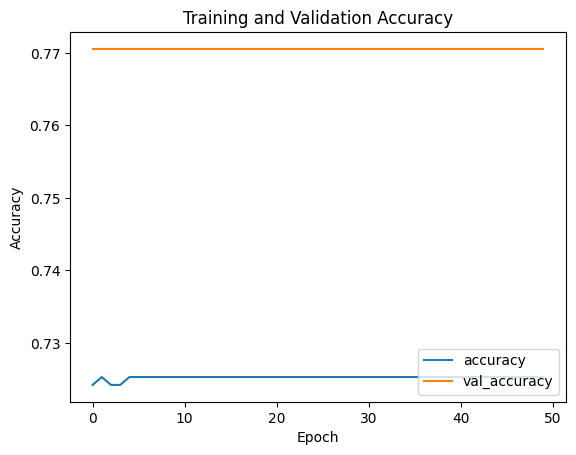

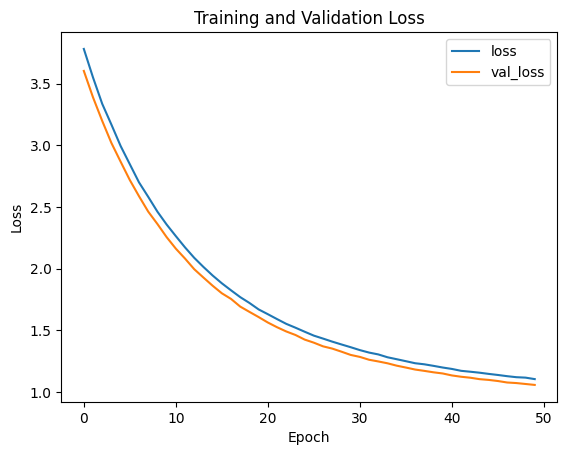

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def transformer_lstm_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Convolutional Layers for Feature Extraction
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten the output for the Transformer
    x = layers.Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)  # Reshape to (timesteps, features)

    # Transformer Encoder
    transformer_layer = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, transformer_layer])  # Residual connection
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    
    # LSTM Layer with Dropout
    x = layers.LSTM(128, kernel_regularizer=regularizers.l2(0.01), return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)  # Add dropout for regularization
    
    # Dense Output Layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # Compile Model
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Define input shape
input_shape = (128, 128, 1)

# Create the model
model = transformer_lstm_model(input_shape)
model.summary()

# Callbacks for optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Fit the model with training data (replace X_train, y_train with your actual training data)
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set (replace X_test, y_test with your actual test data)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Visualize training history
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
